# Fake News Detection

## 1. Imported All the Necessary Packages

In [33]:
import pandas as pd
import numpy as np
import lazypredict
from lazypredict.Supervised import LazyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
import gensim
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

from collections import defaultdict, Counter
import string
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import pandas, xgboost, numpy, textblob, string
from sklearn.metrics import confusion_matrix, f1_score
from scipy import sparse

%matplotlib inline

## 2. Imported Data

In [34]:
data = pd.read_csv('Final_Data.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

,title,text,subject,date,Target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


## 3. Raw Analysis 
### 3.1 Check the rows and columns
##### As the preliminary step, we would like to check the shape of the data & whether there are any nulls present in the data

In [18]:
print('Total rows:', data.shape[0])
print('Total columns:', data.shape[1])
print('Nulls among various columns -')
print(data.isnull().sum())

Total rows: 44898
Total columns: 5
Nulls among various columns -
title      0
text       0
subject    0
date       0
Target     0
dtype: int64


#### As we can see there are around 45K rows, 5 columns & no null values in the data

### 3.2 Checked the class size
##### In the first step, we would like to know the class distribution

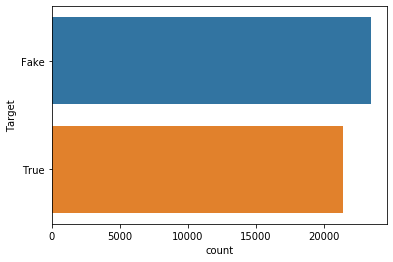

In [19]:
sns.countplot(y='Target', data=data)

#### As we can see, there are slightly more number of Fake news data compared to True news in the dataset

### 3.3 Number of characters & words in each type of news

- The next step is the analysis of title and text columns in a group of Fake and True news. Text statistics visualizations are simple but very insightful techniques
- Here, we wanted to check the character & word count distribution among Fake news & True news. This can give us a rough idea about the news headline length.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f097b5dfa90>,
      dtype=object)

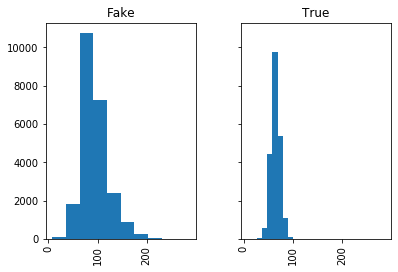

In [20]:
# the number of characters present in each title by labels
data['title'].str.len().hist(by=data['Target'], sharex=True, sharey=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f097b92e410>,
      dtype=object)

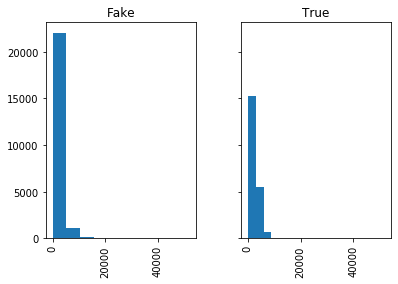

In [21]:
# the number of characters present in each text by labels
data['text'].str.len().hist(by=data['Target'], sharex=True, sharey=True)

#### The main insights, that new’s title, and text characters without preprocessing in true news are shorter than in fake.

##### Now, we will move on to data exploration at a word-level. Let’s plot the number of words appearing in each new’s title and text by the label

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0979809a10>,
      dtype=object)

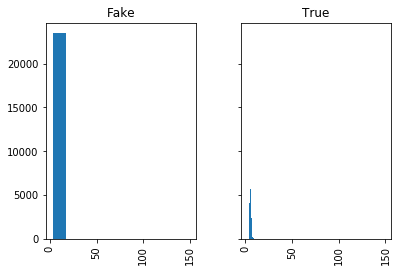

In [22]:
# Word level analysis of title
data['title'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=data['Target'], sharex=True, sharey=True)

/home/affine/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/affine/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f58f067f950>,
      dtype=object)

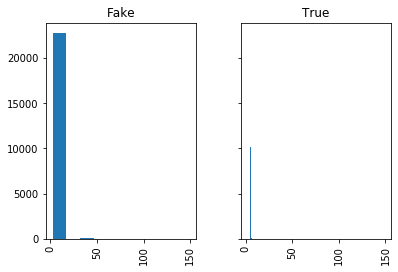

In [11]:
# Word level analysis of title
data['text'].str.split().apply(lambda x:[len(i) for i in x]).map(lambda x: np.mean(x)).hist(by=data['Target'], sharex=True, sharey=True)

- #### The main insights, that new’s title, and text words without preprocessing in True news are shorter than in Fake news.
- #### As we can infer from the above visualizations, character & word count is usually higher in Fake news compared to True news i.e, the Fake News Titles are more wordy

## 4. Basic EDA
### 4.1 Tokens frequently used

In [3]:
# Seperating Fake & True news data to carry further analysis
news_fake = data[data.Target=='Fake'].copy()
news_not_fake = data[data.Target=="True"].copy()

/home/affine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


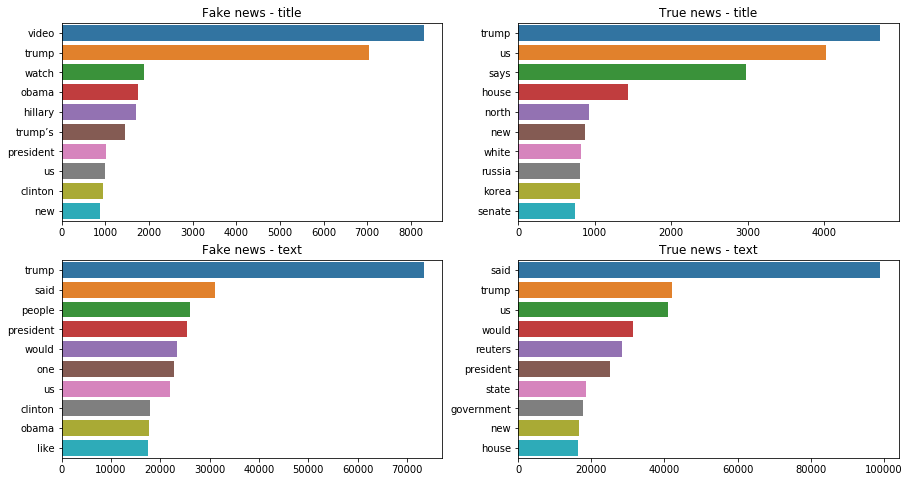

In [44]:
# News analysis
stop = set(stopwords.words('english'))
def analysis_sns(df, title, n):
    df = df.str.lower()
    df = df.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    new = df.str.split()
    new = new.values.tolist()
    corpus_title_fake = [word for i in new for word in i]

    counter = Counter(corpus_title_fake)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[: 100]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x, order=x[: 10], ax=ax[n]).set_title(title)
    
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()
analysis_sns(news_fake['title'], 'Fake news - title', 0)
analysis_sns(news_not_fake['title'], 'True news - title', 1)
analysis_sns(news_fake['text'], 'Fake news - text', 2)
analysis_sns(news_not_fake['text'], 'True news - text', 3)
fig.show()

- #### The corpus of title and text of Fake and True news is different and the order of the words is also different
- #### Tokens like Trump, Hilary, US have been used quite often in both types of news
- #### We can infer from the above visualizations that there is no clear picture of words described in Fake news & True news data

### 4.2 WordCloud
##### The next stage of our exploratory data analysis of the text is Word cloud analysis. Wordcloud is a great way to represent text data. The size and color of each word that appears in the Word cloud indicate it’s frequency or importance

In [26]:
# Function for word cloud
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

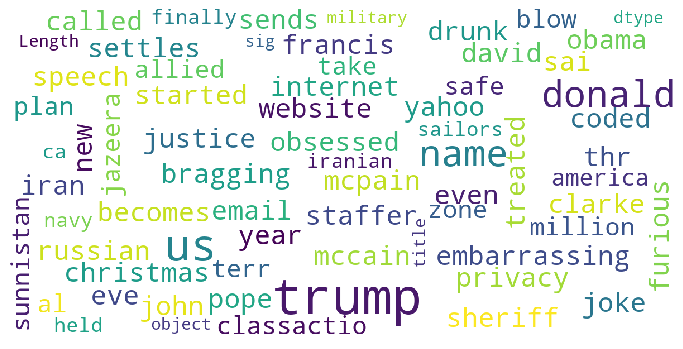

In [45]:
# Word cloud for corpus_title_fake
show_wordcloud(news_fake['title'])

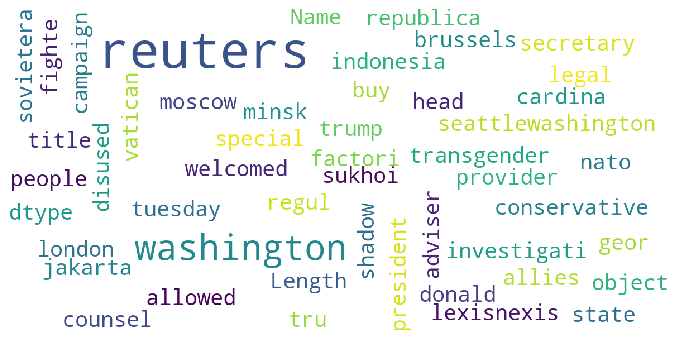

In [46]:
# Word cloud for corpus_title_not_fake
show_wordcloud(news_not_fake['title'])

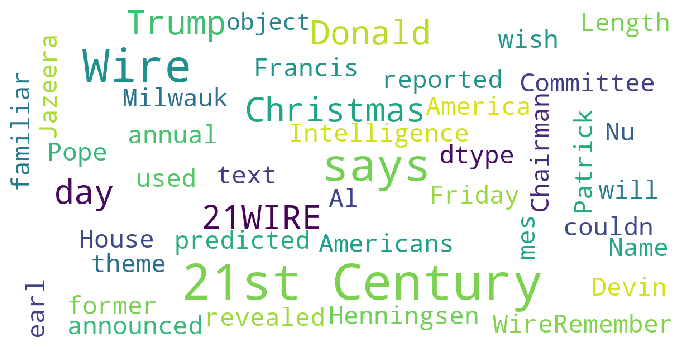

In [27]:
# Word cloud for corpus_text_fake
show_wordcloud(news_fake['text'])

#### Seems like news from 21st Century Wire is mostly fake

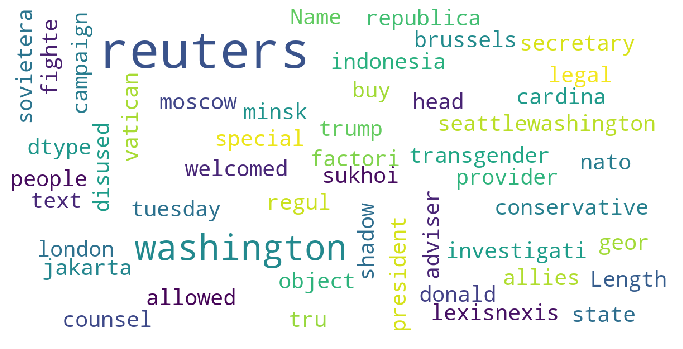

In [48]:
# Word cloud for corpus_text_not_fake
show_wordcloud(news_not_fake['text'])

- #### The topics are properly distributed. Not poining out a particular person (like Trump in Fake)
- #### In the results, we can see how often some words are used in news title and text in Fake or True news.

### 4.3 Ngram Analysis
##### The next step is the Ngram analysis. Ngrams are simply contiguous sequences of n words. Looking at most frequent n-grams can give us a better understanding of the context in which the word was used

In [38]:
# Ngram analysis function
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

/home/affine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



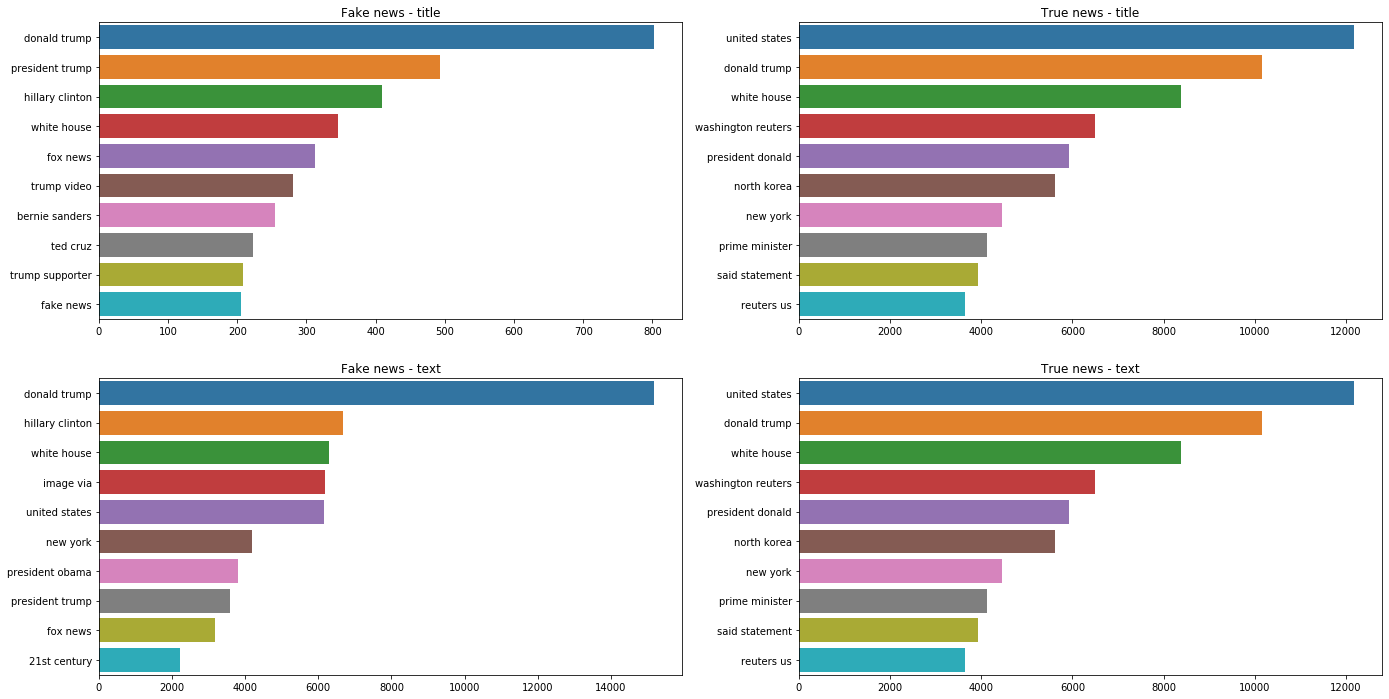

In [88]:
# Ngram analysis
def ngram_analysis(df, title, n, a):
    df = df.str.lower()
    df = df.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    df = df.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    top_n_bigrams = get_top_ngram(df, n)[:10]
    x, y = map(list, zip(*top_n_bigrams))
    sns.barplot(x=y, y=x, order=x[:10], ax=ax[a]).set_title(title)
    
fig, ax = plt.subplots(2, 2, figsize=(23, 12))
ax = ax.flatten()
ngram_analysis(news_fake['title'], 'Fake news - title', 2, 0)
ngram_analysis(news_not_fake['title'], 'True news - title', 2, 1)
ngram_analysis(news_fake['text'], 'Fake news - text', 2, 2)
ngram_analysis(news_not_fake['text'], 'True news - text', 2, 3)
fig.show()

- #### Here we can see that text and title in Fake news Ngrams are somewhat different, but True news is the same.
- #### Trying to create fake image of Hilary Clinton and President Obama
- #### 21st Century news source stills there in fake news
- #### We can roughly infer from above visualtizations that Fake news revolved around US elections due to the presence of words like 'Donald Trump', 'Hilary Clinton', President Obama', 'Fox News' and also included Senator names like 'Bernie Sanders' & 'Ted Cruz'. True news looks like statements involving political news in US

### 4.4 Polarity Distribution Across News

In [78]:
polarity =[]

for i in data['text_preprocessed']:
    _1 = TextBlob(i)
    #print(format(_1.sentiment))
    polarity.append(float(str(_1.sentiment).split("polarity=")[1].split(", subjectivity=")[0]))

data['polarity'] = polarity
fake_final = data[data["Target"]=="Fake"]
true_final = data[data["Target"]=="True"]

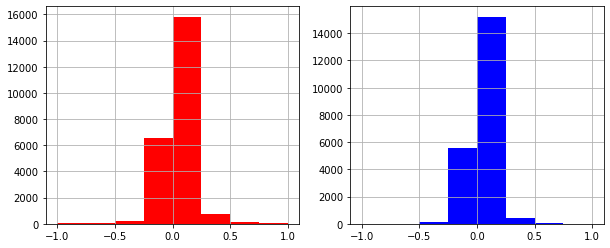

In [83]:
fig, ax =plt.subplots(1,2, figsize=(10, 4))
fake_final['polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax[0],
             color="red",label="Fake News Polarity")
true_final['polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax[1],
             color="blue",label="True News Polarity")

#### Polarity is almost same for both news

## 5. Preprocessing
##### Text preprocessing on dataset for further analysis

In [38]:
stop = set(stopwords.words('english'))

# Text preprocessing
data['text_preprocessed'] = data['text'].str.lower()
data['text_preprocessed'] = data.text_preprocessed.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data['text_preprocessed'] = data['text_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

data['text_preprocessed'] = data.text_preprocessed.apply(lemmatize_text)

In [39]:
# Title preprocessing
data['title_preprocessed'] = data['title'].str.lower()
data['title_preprocessed'] = data.title_preprocessed.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
data['title_preprocessed'] = data['title_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

data['title_preprocessed'] = data.title_preprocessed.apply(lemmatize_text)
data.head()

,title,text,subject,date,Target,text_preprocessed,title_preprocessed
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake,donald trump wish american happy new year leav...,donald trump sends embarrassing new year’s eve...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake,house intelligence committee chairman devin nu...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake,friday revealed former milwaukee sheriff david...,sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake,christmas day donald trump announced would bac...,trump obsessed even obama’s name coded website...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake,pope francis used annual christmas day message...,pope francis called donald trump christmas speech


In [40]:
# Seperating Fake & True news data from the preprocessed dataset
messages_fake=data[data.Target=='Fake'].copy()
messages_not_fake=data[data.Target=='True'].copy()

## 6. Topic Modelling using LDA

- ##### Making a topic modeling to compare fake and not fake news. Topic modeling is the process of using unsupervised learning techniques to extract the main topics that occur in a collection of documents.
- ##### Latent Dirichlet Allocation (LDA) is an easy to use and efficient model for topic modeling. Each document is represented by the distribution of topics and each topic is represented by the distribution of words.
- ##### Once we categorize our documents in topics we can dig into further data exploration for each topic or topic group.

In [36]:
# Preprocess function for LDA
def preprocess_news(df, column):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for news in df[column]:
        words = [w for w in word_tokenize(news) if (w not in stop)]
        
        words = [lem.lemmatize(w) for w in words if len(w) > 2]
        
        corpus.append(words)
    return corpus

In [56]:
#LDA for corpus_title_fake
corpus = preprocess_news(messages_fake,'title_preprocessed')
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.024*"trump" + 0.021*"house" + 0.015*"court" + 0.013*"republican" + 0.012*"white" + 0.010*"bill" + 0.009*"senate" + 0.008*"say" + 0.008*"vote" + 0.008*"tax"'),
 (1,
  '0.032*"say" + 0.022*"trump" + 0.016*"north" + 0.016*"korea" + 0.010*"russia" + 0.009*"state" + 0.009*"china" + 0.008*"minister" + 0.008*"talk" + 0.007*"deal"'),
 (2,
  '0.041*"video" + 0.037*"trump" + 0.010*"hillary" + 0.009*"watch" + 0.006*"obama" + 0.006*"woman" + 0.006*"clinton" + 0.006*"news" + 0.005*"get" + 0.005*"black"'),
 (3,
  '0.010*"obama" + 0.009*"police" + 0.009*"new" + 0.008*"clinton" + 0.008*"trump" + 0.008*"president" + 0.007*"opposition" + 0.006*"leader" + 0.006*"poll" + 0.006*"say"')]

In [57]:
#Vizual for corpus_title_fake
pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
# pyLDAvis.save_html(vis, 'lda_fake_title.html')

- #### Here we can have a look at topics and observe that, in topic 1 we can find terms relating to social news
- #### In topic 2 there are titles involving other countries or international news
- #### In topic 3, we can find words relating to political news
- #### In topic 4, we can find words realting to criminal news

In [58]:
#LDA for corpus_title_not_fake
corpus = preprocess_news(messages_not_fake, 'title_preprocessed')
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
# pyLDAvis.save_html(vis, 'lda_not_fake_title.html')
lda_model.show_topics()

[(0,
  '0.025*"trump" + 0.024*"house" + 0.015*"say" + 0.015*"republican" + 0.014*"white" + 0.012*"bill" + 0.012*"senate" + 0.010*"tax" + 0.008*"vote" + 0.008*"new"'),
 (1,
  '0.012*"minister" + 0.011*"party" + 0.011*"say" + 0.011*"myanmar" + 0.009*"police" + 0.008*"leader" + 0.008*"rohingya" + 0.007*"opposition" + 0.007*"state" + 0.007*"new"'),
 (2,
  '0.052*"trump" + 0.029*"north" + 0.029*"korea" + 0.020*"say" + 0.014*"court" + 0.011*"china" + 0.009*"south" + 0.008*"nuclear" + 0.008*"russia" + 0.006*"call"'),
 (3,
  '0.026*"say" + 0.009*"talk" + 0.009*"irma" + 0.008*"syria" + 0.007*"russia" + 0.007*"brexit" + 0.007*"turkey" + 0.006*"may" + 0.005*"state" + 0.005*"hurricane"')]

- #### Topic 1 revolved around elections and campaigns
- #### Topic 2 talks about relations with other countries
- #### Topic 3 involves violence with other countries
- #### Topic 4 we can find words relating to opression

##### As we can see topic modeling of fake and not fake news titles are different.

In [59]:
#LDA for corpus_text_fake
corpus = preprocess_news(messages_fake, 'text_preprocessed')
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
# pyLDAvis.save_html(vis, 'lda_fake_text.html')
lda_model.show_topics()

[(0,
  '0.034*"trump" + 0.010*"president" + 0.008*"donald" + 0.007*"republican" + 0.006*"said" + 0.006*"clinton" + 0.006*"hillary" + 0.005*"would" + 0.005*"obama" + 0.005*"campaign"'),
 (1,
  '0.007*"people" + 0.007*"woman" + 0.007*"said" + 0.005*"one" + 0.005*"black" + 0.005*"police" + 0.005*"like" + 0.004*"video" + 0.004*"say" + 0.003*"white"'),
 (2,
  '0.007*"state" + 0.005*"american" + 0.005*"people" + 0.005*"would" + 0.004*"year" + 0.004*"obama" + 0.004*"country" + 0.004*"government" + 0.004*"said" + 0.003*"america"'),
 (3,
  '0.009*"clinton" + 0.007*"said" + 0.006*"state" + 0.005*"fbi" + 0.005*"email" + 0.005*"court" + 0.004*"department" + 0.004*"official" + 0.004*"investigation" + 0.003*"law"')]

- #### Topic 1 revolves around elections and campaigns
- #### Topic 2 involves domestic news & basic necessities
- #### Topic 3 talks about persecution against people
- #### Topic 4 centers around law and investigation

In [41]:
#LDA for corpus_text_not_fake
corpus = preprocess_news(messages_not_fake, 'text_preprocessed')
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dic,                                    
                                   passes = 2,
                                   workers = 2)
pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
# pyLDAvis.save_html(vis, 'lda_not_fake_text.html')
lda_model.show_topics()

[(0,
  '0.019*"said" + 0.012*"trump" + 0.009*"would" + 0.007*"republican" + 0.007*"state" + 0.006*"president" + 0.005*"court" + 0.005*"reuters" + 0.005*"party" + 0.005*"house"'),
 (1,
  '0.024*"said" + 0.008*"state" + 0.007*"reuters" + 0.005*"government" + 0.004*"people" + 0.004*"would" + 0.004*"president" + 0.004*"trump" + 0.004*"year" + 0.004*"united"'),
 (2,
  '0.015*"said" + 0.007*"trump" + 0.006*"state" + 0.006*"would" + 0.006*"reuters" + 0.005*"percent" + 0.005*"president" + 0.005*"north" + 0.004*"year" + 0.004*"election"')]

- #### We can find words relating to elections & campaign in topic 1
- #### Topic 2 has words relating to defence & security
- #### Topic 3 has miscellaneous words

#### The results show, that topic of Fake and True news are different, and one more insight that topic title and text are different in Fake news.

## Conclusions

- #### The results of text exploratory data analysis are different techniques to compare Fake and True news
- #### With this approach, we can create our own rules to detect fake. This way is quite difficult and needs a lot of routine works
- #### Also, in this example we can see, that dataset full of news about the USA elections and with this data would be difficult to detect some general rules and style in fake news.

In [8]:
df_ad = pd.read_csv('Emo.csv')
df_ad = df_ad.drop('Unnamed: 0', axis=1)
df_ad['text_preprocessed'] = data['text_preprocessed']
df_ad.head(2)

,title,text,subject,date,Target,title_preprocessed,text_preprocessed,Word_count,polarity,subjectivity,Positiveness_Ratio
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake,donald trump sends embarrassing new year’s eve...,donald trump wish american happy new year leav...,287,0.10,0.60,1.07
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,179,-0.01,0.33,0.85


## 7. Modelling

### We tried different bag of word techniques for modelling -
- #### Count vectorizer
- #### TFIDF Unigram
- #### TFIDF Ngram
- #### TFIDF Ngram Character level

In [6]:
# create a dataframe using texts and lables
trainDF = pd.DataFrame()
trainDF['text'] = data["text_preprocessed"]
trainDF['label'] = data["Target"]
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'], test_size=0.20)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [7]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x)
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

In [30]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    global i
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    #Get the confusion matrix
    cf_matrix = confusion_matrix(valid_y, predictions)
    #print(cf_matrix)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',ax=ax.flat[i])
    i=i+1
    
    return metrics.accuracy_score(valid_y, predictions), metrics.f1_score(valid_y, predictions)

NB, Count Vectors Accuracy:  0.974521158129176
NB, Count Vectors F1score:  0.9741316931982633
NB, WordLevel TF-IDF Accuracy:  0.9615144766146994
NB, WordLevel TF-IDF f1score:  0.9608198802829676
NB, N-Gram Vectors Accuracy:  0.9738975501113586
NB, N-Gram Vectors f1score:  0.9734240362811791
NB, CharLevel Vectors Accuracy:  0.9649888641425389
NB, CharLevel Vectors f1score:  0.9638687137997609


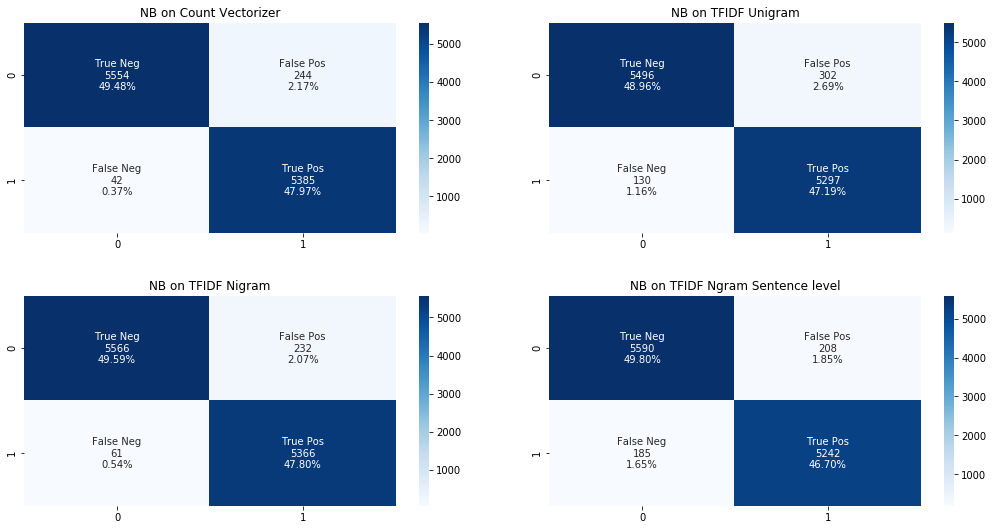

In [31]:
fig, ax =plt.subplots(2,2)
ax = ax.flatten()
ax[0].set_title('NB on Count Vectorizer')
ax[1].set_title('NB on TFIDF Unigram')
ax[2].set_title('NB on TFIDF Nigram')
ax[3].set_title('NB on TFIDF Ngram Sentence level')
plt.gcf().set_size_inches(15, 8)
fig.tight_layout(pad=3.0)
fig.savefig("Too much Confusion.png")
i=0
# Naive Bayes on Count Vectors
accuracy, f1score = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors Accuracy: ", accuracy)
print("NB, Count Vectors f1score: ", f1score)

# Naive Bayes on Word Level TF IDF Vectors
accuracy, f1score = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF Accuracy: ", accuracy)
print("NB, WordLevel TF-IDF f1score: ", f1score)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy, f1score = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors Accuracy: ", accuracy)
print("NB, N-Gram Vectors f1score: ", f1score)

# Naive Bayes on Character Level TF IDF Vectors
accuracy, f1score = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors Accuracy: ", accuracy)
print("NB, CharLevel Vectors f1score: ", f1score)

- #### Nearly all bag of words techiques performance was good
- #### TFIDF Ngram & Count Vectorizer show slighlty better results over others

### We ran different models on TFIDF Ngram using just Text data

In [18]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=500)
tfidf = tfidf_vect_ngram.fit_transform(data['text_preprocessed'])
TF_IDF_Data = pd.DataFrame(tfidf.toarray(), columns=tfidf_vect_ngram.get_feature_names())
Ad_data = pd.concat([data,TF_IDF_Data],axis=1)
Ad_data = Ad_data.drop(['title', 'text', 'subject', 'date', 'title_preprocessed'],axis=1)
Ad_data.head(2)

,Target,text_preprocessed,10 year,20 percent,2016 election,2016 presidential,21st century,21st century wire,8 election,abc news,...,would make,would take,xi jinping,year ago,year old,yet another,york city,york reuters,york time,young people
0,Fake,donald trump wish american happy new year leav...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.18,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00
1,Fake,house intelligence committee chairman devin nu...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [25]:
# create a dataframe using texts and lables
X = Ad_data[[i for i in list(Ad_data.columns) if i not in ["text_preprocessed","Target"]]]
X_val = X.loc[:,:].values
Y = Ad_data["Target"]
Y_val = Y.loc[:,].values
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X,Y)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [26]:
clf = LazyClassifier()
models,predictions = clf.fit(train_x, valid_x, train_y, valid_y)
models

100%|██████████| 30/30 [33:14<00:00, 66.47s/it] 


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.97,0.97,0.97,0.97,35.27
RandomForestClassifier,0.97,0.97,0.97,0.97,25.75
LogisticRegression,0.97,0.97,0.97,0.97,3.01
CalibratedClassifierCV,0.97,0.97,0.97,0.97,56.27
SVC,0.97,0.97,0.97,0.97,474.29
LinearSVC,0.97,0.97,0.97,0.97,15.93
LGBMClassifier,0.97,0.97,0.97,0.97,18.96
SGDClassifier,0.97,0.96,0.96,0.97,3.03
BaggingClassifier,0.96,0.96,0.96,0.96,49.10


- #### Most of the models performances are good
- #### Naive Bayes time complexity & accuracy combined looks better over others
- #### We can also choose logistic regression since it is easier to implement and gives a slighty higher accuracy & f1score

### Now we ran different models including additional features

In [19]:
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=500)
tfidf = tfidf_vect_ngram.fit_transform(df_ad['text_preprocessed'])
TF_IDF_Data = pd.DataFrame(tfidf.toarray(), columns=tfidf_vect_ngram.get_feature_names())
Ad_data = pd.concat([df_ad,TF_IDF_Data],axis=1)
Ad_data = Ad_data.drop(['title', 'text', 'subject', 'date', 'title_preprocessed'],axis=1)
Ad_data.head(2)

,Target,text_preprocessed,Word_count,polarity,subjectivity,Positiveness_Ratio,10 year,20 percent,2016 election,2016 presidential,...,would make,would take,xi jinping,year ago,year old,yet another,york city,york reuters,york time,young people
0,Fake,donald trump wish american happy new year leav...,287,0.10,0.60,1.07,0.00,0.00,0.00,0.00,...,0.18,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00
1,Fake,house intelligence committee chairman devin nu...,179,-0.01,0.33,0.85,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [20]:
# create a dataframe using texts and lables
X = Ad_data[[i for i in list(Ad_data.columns) if i not in ["text_preprocessed","Target"]]]
X_val = X.loc[:,:].values
Y = Ad_data["Target"]
Y_val = Y.loc[:,].values
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X,Y)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [21]:
clf = LazyClassifier()
models, predictions = clf.fit(train_x, valid_x, train_y, valid_y)
models

100%|██████████| 30/30 [34:54<00:00, 69.80s/it] 


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.98,0.98,0.98,0.98,31.48
RandomForestClassifier,0.97,0.97,0.97,0.97,21.80
LGBMClassifier,0.97,0.97,0.97,0.97,21.13
SVC,0.97,0.97,0.97,0.97,485.41
LogisticRegression,0.97,0.97,0.97,0.97,3.54
CalibratedClassifierCV,0.97,0.97,0.97,0.97,62.05
LinearSVC,0.97,0.97,0.97,0.97,16.01
SGDClassifier,0.96,0.96,0.96,0.96,2.26
BaggingClassifier,0.96,0.96,0.96,0.96,48.65


- #### Features like emotions ratio, length of words, polarity and subjectivity helped the models to perform slightly better
- #### Tree based classifiers are performing good but taking slightly more time
- #### Again we can see logistic regression giving better results in quick time